In [1]:
from ReebGraph import SequentialReebGraph
from tests.simulator import brownian_motion
import numpy as np
import matplotlib.pyplot as plt

In [2]:
TRAJECTORY_LENGTH = int(24 * 60 * 60 / 15)

trajectories = np.array(
    # [brownian_motion(TRAJECTORY_LENGTH, 2) for i in range(60)]
    [brownian_motion(30, 1) for i in range(30)]
)

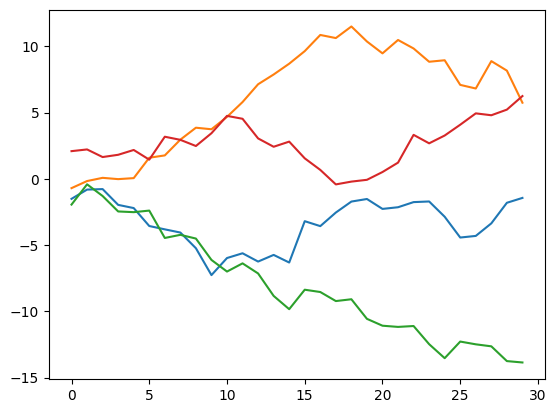

In [3]:
for _ in range(4):
    plt.plot(trajectories[_])

In [ ]:
# split the trajectories into N sets
N = 2
trajectories_split = np.array_split(trajectories, N)

reeb_split = []
for i in range(N):
    reeb_split.append(SequentialReebGraph(epsilon=2.5, store_trajectories=True))
    reeb_split[i].append_trajectories(trajectories_split[i])

reeb1 = reeb_split[0]
reeb2 = reeb_split[1]

reeb_merge = reeb1.union(reeb2, adjust_epsilon=1)

reeb_combined = SequentialReebGraph(epsilon=2, store_trajectories=True)
reeb_combined.append_trajectories(trajectories)

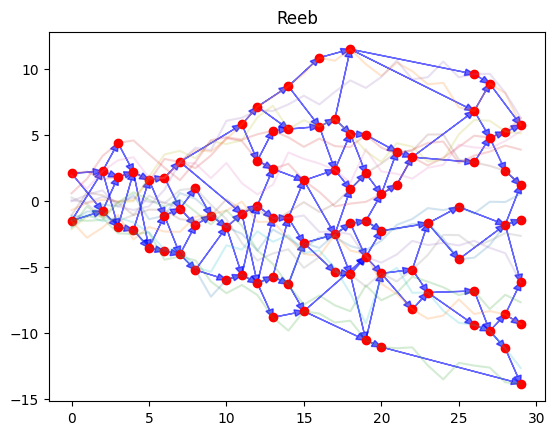

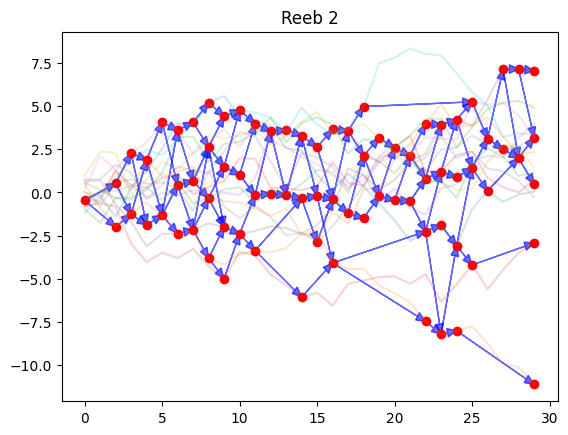

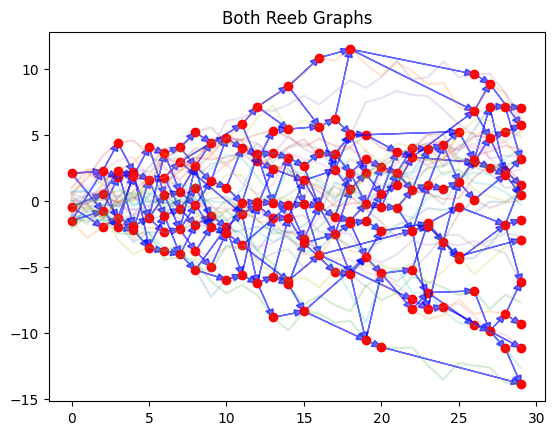

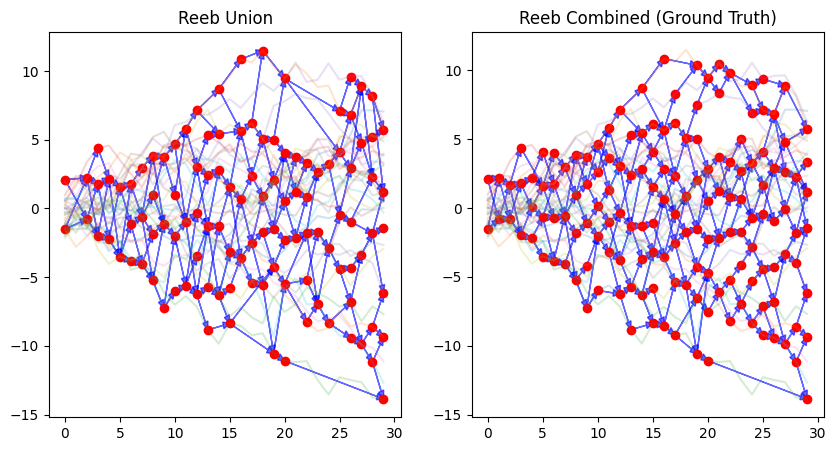

In [10]:
def plot_reeb(reeb):
    for edge in reeb.edges:
        dx = edge[1][0] - edge[0][0]
        dy = edge[1][1] - edge[0][1]
        plt.arrow(edge[0][0], edge[0][1], dx, dy, 
                head_width=0.5, head_length=0.6, fc='b', ec='b', 
                length_includes_head=True, alpha=0.6)

    for node in reeb.nodes:
        plt.scatter(node[0], node[1], c='r')
        
    for trajectory in reeb.trajectories:
        plt.plot(trajectory, alpha=0.2)

plt.figure()
plt.title("Reeb")
plot_reeb(reeb1)

plt.figure()
plt.title("Reeb 2")
plot_reeb(reeb2)

plt.figure()
plt.title("Both Reeb Graphs")
plot_reeb(reeb1)
plot_reeb(reeb2)


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Reeb Union")
plot_reeb(reeb_merge)

plt.subplot(1, 2, 2)
plt.title("Reeb Combined (Ground Truth)")
plot_reeb(reeb_combined)

In [11]:
AGENT_COUNT = 10
trajectories = np.array(
    # two agents worth of trajectory data
    [brownian_motion(TRAJECTORY_LENGTH, 2) for i in range(AGENT_COUNT * 30)]
)
print(trajectories.shape)

(300, 5760, 2)


In [12]:
# naive method: append all trajectories
reeb_naive = SequentialReebGraph(epsilon=25)
reeb_naive.append_trajectories(trajectories)

print(f"Nodes: {len(reeb_naive.nodes)}, Edges: {len(reeb_naive.edges)}")

Nodes: 112279, Edges: 208643


In [ ]:
# split the trajectories into N sets
N = 10
trajectories_split = np.array_split(trajectories, N)

reeb_split = []
for i in range(N):
    reeb_split.append(SequentialReebGraph(epsilon=25))
    reeb_split[i].append_trajectories(trajectories_split[i], compute_graph=False)


In [14]:
reeb_combined = reeb_split[0]

for i in range(1, N - 1):
    reeb_combined = reeb_combined.union(reeb_split[0], compute_graph=False)

reeb_combined = reeb_combined.union(reeb_split[0]) 
print(f"Nodes: {len(reeb_combined.nodes)}, Edges: {len(reeb_combined.edges)}")

KeyboardInterrupt: 

KeyboardInterrupt: 

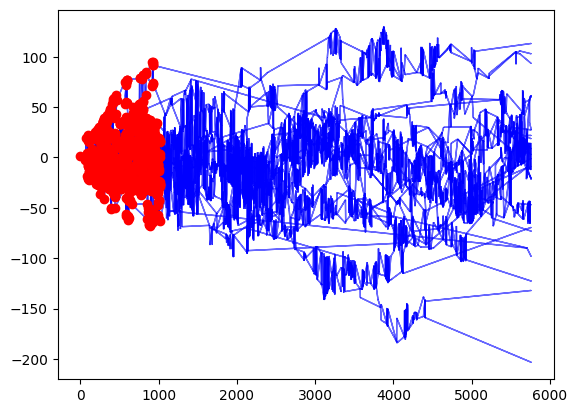

In [27]:
plot_reeb(reeb_combined)